# InfoGAN by Pytorch

### Data loading
Load MNIST dataset and show parts of images

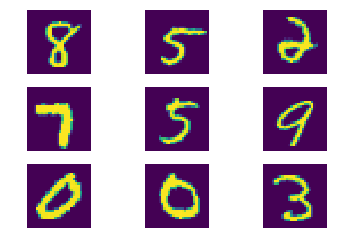

In [ ]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset = dset.MNIST('./dataset', transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=1)
for batch_data in dataloader:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(batch_data[0].numpy()[i,0,:,:])
        plt.axis('off')
    plt.show()
    break

## Network structure

FrontEnd structure（up part of D and Q）、Dicriminator(D)、Generator(G) and Q network

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class FrontEnd(nn.Module):

  def __init__(self):
    super(FrontEnd, self).__init__()

    self.main = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Conv2d(64, 128, 4, 2, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Conv2d(128, 1024, 7, bias=False),
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(0.1, inplace=True),
    )

  def forward(self, x):
    output = self.main(x)
    return output

class D(nn.Module):

  def __init__(self):
    super(D, self).__init__()
    
    self.main = nn.Sequential(
      nn.Conv2d(1024, 1, 1),
      nn.Sigmoid()
    )
    

  def forward(self, x):
    output = self.main(x).view(-1, 1)
    return output


class Q(nn.Module):

  def __init__(self):
    super(Q, self).__init__()

    self.conv = nn.Conv2d(1024, 128, 1, bias=False)
    self.bn = nn.BatchNorm2d(128)
    self.lReLU = nn.LeakyReLU(0.1, inplace=True)
    self.conv_disc = nn.Conv2d(128, 10, 1)
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):

    y = self.conv(x)

    disc_logits = self.conv_disc(y).squeeze()

    mu = self.conv_mu(y).squeeze()
    var = self.conv_var(y).squeeze().exp()

    return disc_logits, mu, var 


class G(nn.Module):

  def __init__(self):
    super(G, self).__init__()

    self.main = nn.Sequential(
      nn.ConvTranspose2d(74, 1024, 1, 1, bias=False),
      nn.BatchNorm2d(1024),
      nn.ReLU(True),
      nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(True),
      nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(True),
      nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
      nn.Sigmoid()
    )

  def forward(self, x):
    output = self.main(x)
    return output


### Discriminator Structure

D part: 1 output

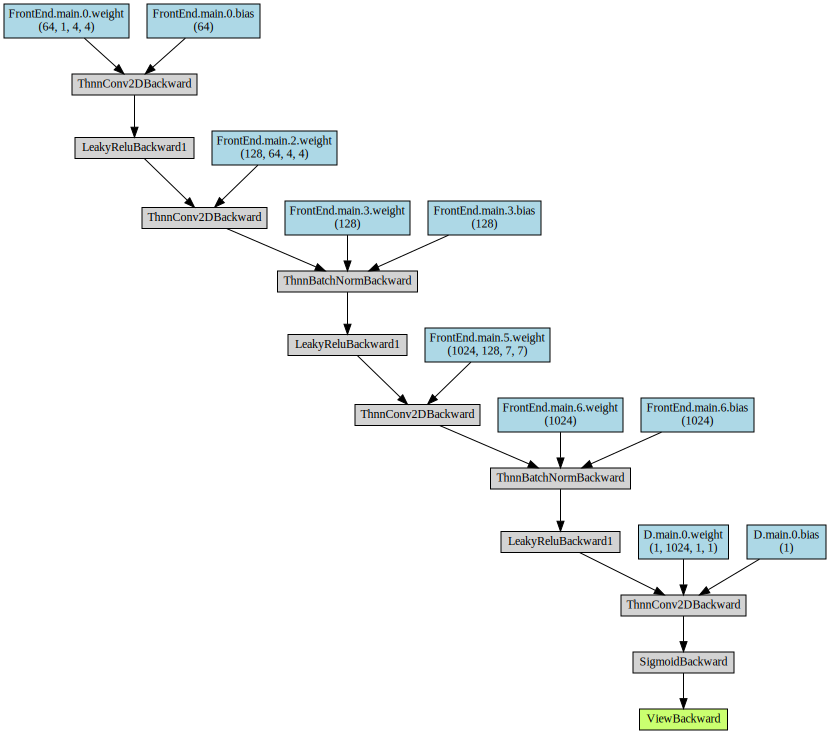

In [3]:
from torchviz import make_dot

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.FrontEnd = FrontEnd()
        self.D = D()
        self.Q = Q()
    def forward(self,x):
        output = self.FrontEnd(x)
        output1 = self.D(output)
        output2 = self.Q(output)
        return output1,output2
    
model = Discriminator()

for batch_data in dataloader:
    output1,output2 = model(Variable(batch_data[0]))
    break

make_dot(output1, params=dict(model.named_parameters()))

Q part: 3 output

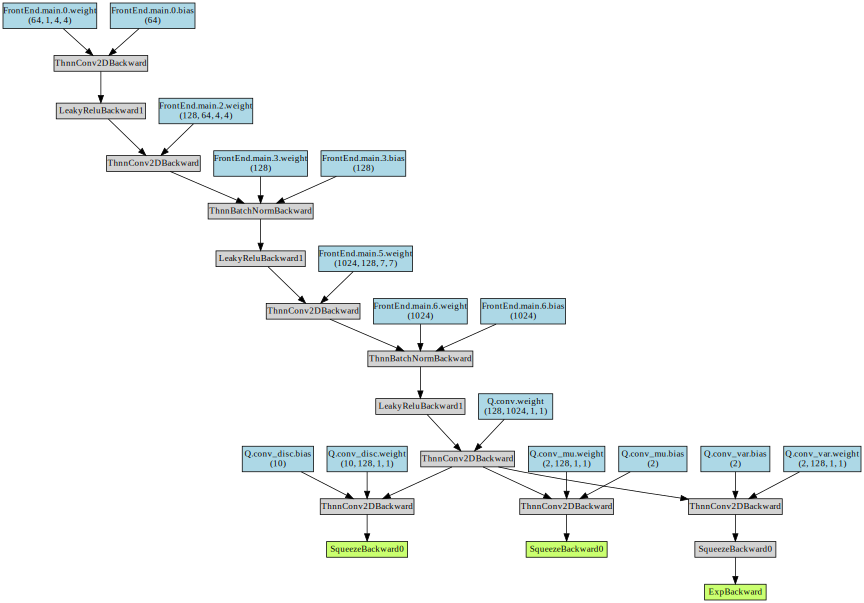

In [4]:
make_dot(output2, params=dict(model.named_parameters()))

### Weight Initialization

If the block is convolutional layer, then use normal distribution with (0,0.02);
 If the block is BatchNorm layer, then use normal distribution with (1,0.02);

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
# define network
fe = FrontEnd()
d = D()
q = Q()
g = G()

# implement network
for i in [fe, d, q, g]:
    i.cuda()
    i.apply(weights_init) 

### Variable Initialization

In [6]:
batch_size = 100

def noise_sample(dis_c, con_c, noise, bs):
    
    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0
    dis_c.data.copy_(torch.Tensor(c))
    con_c.data.uniform_(-1.0, 1.0)
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)

    return z, idx



real_x = torch.FloatTensor(batch_size, 1, 28, 28).cuda()
label = torch.FloatTensor(batch_size, 1).cuda()
dis_c = torch.FloatTensor(batch_size, 10).cuda()
con_c = torch.FloatTensor(batch_size, 2).cuda()
noise = torch.FloatTensor(batch_size, 62).cuda()

real_x = Variable(real_x)
label = Variable(label, requires_grad=False)
dis_c = Variable(dis_c)
con_c = Variable(con_c)
noise = Variable(noise)

### Loss function and Optimizer

In [7]:
import torch.optim as optim

class log_gaussian:

  def __call__(self, x, mu, var):

    logli = -0.5*(var.mul(2*np.pi)+1e-6).log() - (x-mu).pow(2).div(var.mul(2.0)+1e-6)
    
    return logli.sum(1).mean().mul(-1)

criterionD = nn.BCELoss().cuda()
criterionQ_dis = nn.CrossEntropyLoss().cuda()
criterionQ_con = log_gaussian()

optimD = optim.Adam([{'params':fe.parameters()}, {'params':d.parameters()}], lr=0.0002, betas=(0.5, 0.99))
optimG = optim.Adam([{'params':g.parameters()}, {'params':q.parameters()}], lr=0.001, betas=(0.5, 0.99))

### Fixed random variables

In [8]:
import numpy as np

c = np.linspace(-1, 1, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)

c1 = np.hstack([c, np.zeros_like(c)])
c2 = np.hstack([np.zeros_like(c), c])

idx = np.arange(10).repeat(10)
one_hot = np.zeros((100, 10))
one_hot[range(100), idx] = 1
fix_noise = torch.Tensor(100, 62).uniform_(-1, 1)

### Strat Training with 10 epoch

Epoch/Iter:0/0, Dloss: 1.4909820556640625, Gloss: 3.5332746505737305


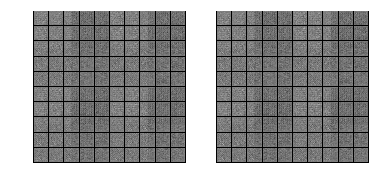

Epoch/Iter:0/200, Dloss: 0.9541735649108887, Gloss: 1.1528440713882446


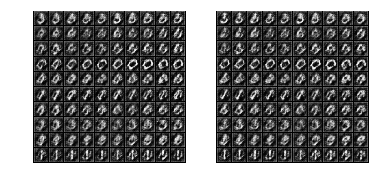

Epoch/Iter:0/400, Dloss: 1.1684736013412476, Gloss: 1.044100046157837


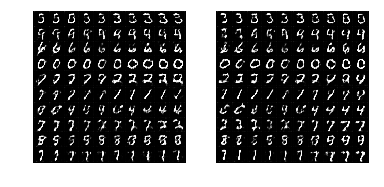

Epoch/Iter:1/0, Dloss: 1.1981992721557617, Gloss: 1.0131969451904297


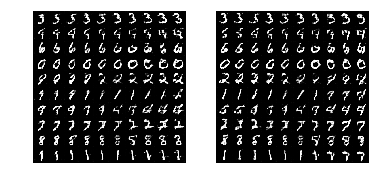

Epoch/Iter:1/200, Dloss: 1.1508889198303223, Gloss: 1.0041333436965942


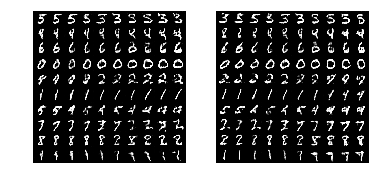

Epoch/Iter:1/400, Dloss: 1.1868360042572021, Gloss: 0.9154004454612732


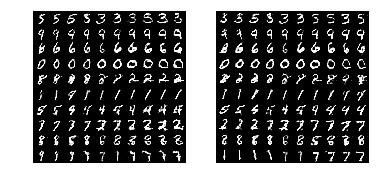

Epoch/Iter:2/0, Dloss: 1.1733132600784302, Gloss: 0.9303388595581055


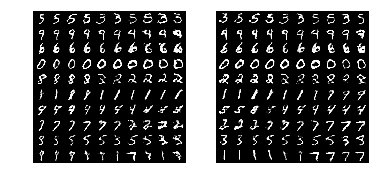

Epoch/Iter:2/200, Dloss: 1.1669888496398926, Gloss: 0.9501320123672485


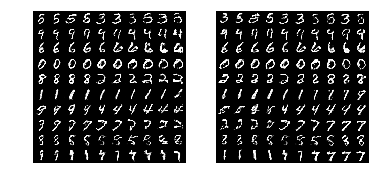

Epoch/Iter:2/400, Dloss: 1.1562294960021973, Gloss: 0.9155480861663818


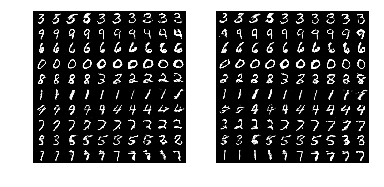

Epoch/Iter:3/0, Dloss: 1.1619434356689453, Gloss: 1.0613945722579956


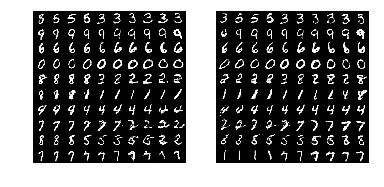

Epoch/Iter:3/200, Dloss: 1.2105803489685059, Gloss: 0.9307080507278442


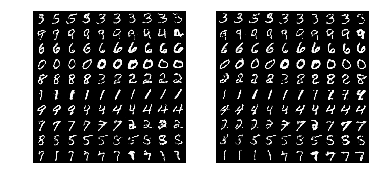

Epoch/Iter:3/400, Dloss: 1.1530327796936035, Gloss: 0.947991669178009


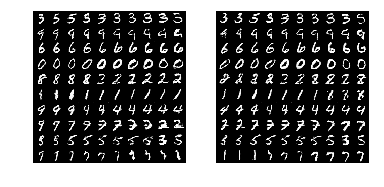

Epoch/Iter:4/0, Dloss: 1.211963415145874, Gloss: 0.8736316561698914


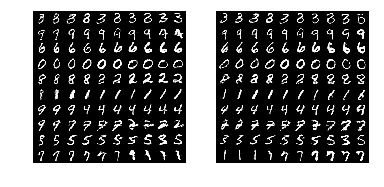

Epoch/Iter:4/200, Dloss: 1.1756408214569092, Gloss: 0.9997830390930176


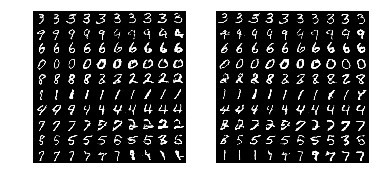

Epoch/Iter:4/400, Dloss: 1.143228530883789, Gloss: 0.946704626083374


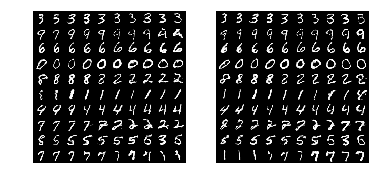

Epoch/Iter:5/0, Dloss: 1.2399975061416626, Gloss: 0.9157039523124695


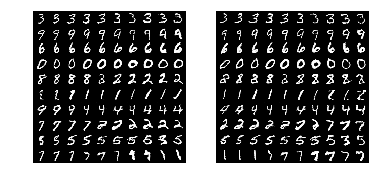

Epoch/Iter:5/200, Dloss: 1.1796321868896484, Gloss: 0.9663877487182617


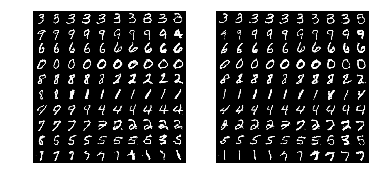

Epoch/Iter:5/400, Dloss: 1.1711764335632324, Gloss: 0.9207014441490173


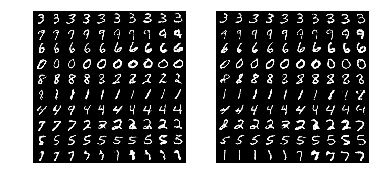

Epoch/Iter:6/0, Dloss: 1.1898688077926636, Gloss: 0.8900500535964966


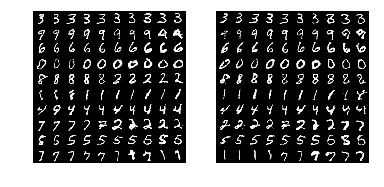

Epoch/Iter:6/200, Dloss: 1.21233069896698, Gloss: 1.0123471021652222


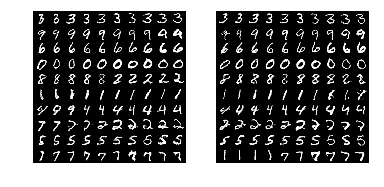

Epoch/Iter:6/400, Dloss: 1.2582179307937622, Gloss: 1.0178062915802002


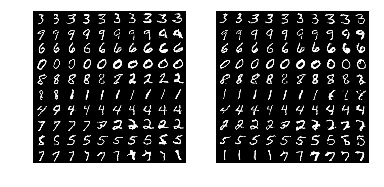

Epoch/Iter:7/0, Dloss: 1.1492832899093628, Gloss: 0.9688502550125122


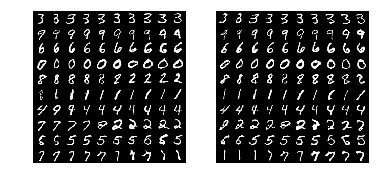

Epoch/Iter:7/200, Dloss: 1.069413185119629, Gloss: 1.0505104064941406


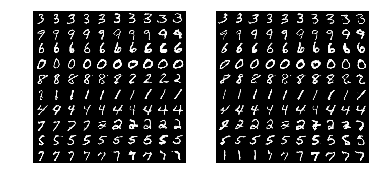

Epoch/Iter:7/400, Dloss: 1.1604738235473633, Gloss: 0.9779308438301086


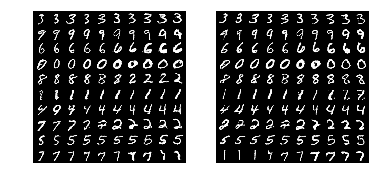

Epoch/Iter:8/0, Dloss: 1.098969578742981, Gloss: 1.0263004302978516


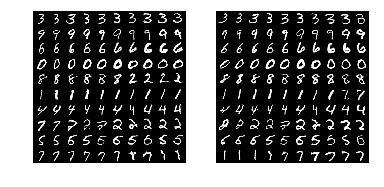

Epoch/Iter:8/200, Dloss: 1.1890478134155273, Gloss: 0.995490312576294


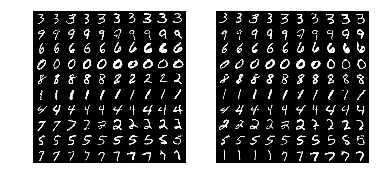

Epoch/Iter:8/400, Dloss: 1.1319212913513184, Gloss: 0.9889960289001465


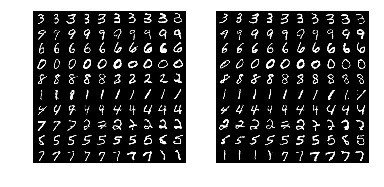

Epoch/Iter:9/0, Dloss: 1.1402239799499512, Gloss: 0.9824175834655762


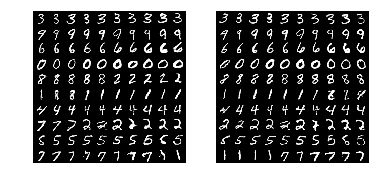

Epoch/Iter:9/200, Dloss: 1.1354349851608276, Gloss: 1.1107100248336792


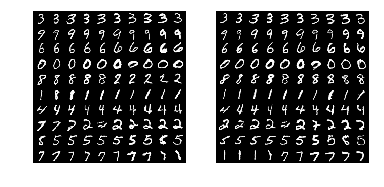

Epoch/Iter:9/400, Dloss: 1.2995569705963135, Gloss: 1.139317274093628


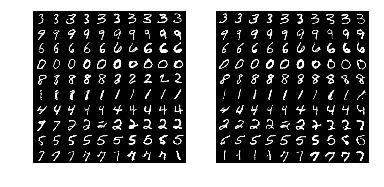

In [9]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2

for epoch in range(10):
    for num_iters, batch_data in enumerate(dataloader, 0):

        # real part
        optimD.zero_grad()
        x, _ = batch_data
        bs = x.size(0)
        
        real_x.data.resize_(x.size())
        label.data.resize_(bs, 1)
        dis_c.data.resize_(bs, 10)
        con_c.data.resize_(bs, 2)
        noise.data.resize_(bs, 62)

        real_x.data.copy_(x)
        fe_out1 = fe(real_x)
        probs_real = d(fe_out1)
        label.data.fill_(1)
        loss_real = criterionD(probs_real, label)
        loss_real.backward()

        # fake part
        z, idx = noise_sample(dis_c, con_c, noise, bs)
        fake_x = g(z)
        fe_out2 = fe(fake_x.detach())
        probs_fake = d(fe_out2)
        label.data.fill_(0)
        loss_fake = criterionD(probs_fake, label)
        loss_fake.backward()

        D_loss = loss_real + loss_fake

        optimD.step()

        # G and Q part
        optimG.zero_grad()

        fe_out = fe(fake_x)
        probs_fake = d(fe_out)
        label.data.fill_(1.0)

        reconstruct_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = q(fe_out)
        class_ = torch.LongTensor(idx).cuda()
        target = Variable(class_)
        dis_loss = criterionQ_dis(q_logits, target)
        con_loss = criterionQ_con(con_c, q_mu, q_var) * 0.1

        G_loss = reconstruct_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if num_iters % 200 == 0:
            print('Epoch/Iter:{0}/{1}, Dloss: {2}, Gloss: {3}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss.data.cpu().numpy())
            )

            noise.data.copy_(fix_noise)
            dis_c.data.copy_(torch.Tensor(one_hot))
            
            # output with c1
            con_c.data.copy_(torch.from_numpy(c1))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = g(z)
            save_image(x_save.data, './tmp/E{}B{}_1.png'.format(epoch, num_iters), nrow=10)
            img = cv2.imread('./tmp/E{}B{}_1.png'.format(epoch, num_iters))
            plt.subplot(121)
            plt.imshow(img)
            plt.axis('off')
            # output with c2
            con_c.data.copy_(torch.from_numpy(c2))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = g(z)
            save_image(x_save.data, './tmp/E{}B{}_2.png'.format(epoch, num_iters), nrow=10)
            img = cv2.imread('./tmp/E{}B{}_2.png'.format(epoch, num_iters))
            plt.subplot(122)
            plt.imshow(img)
            plt.axis('off')
            plt.show()